In [ ]:
# pip install lightgbm --install-option=--gpu

In [ ]:
# pip install lightgbm

In [ ]:
# pip install --upgrade openpyxl

In [1]:
# Read Files
import pandas as pd
import json
import re
import os
import numpy as np
import pickle
import joblib

# Feature Extraction
# from memory_profiler import profile
from scipy.sparse import vstack, save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import gc 
from sklearn.decomposition import TruncatedSVD

# Model
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

## Feature Extraction

In [ ]:
# labels = pd.read_csv("training_set_metadata.csv", sep = ';')
# labels.head(10)

In [ ]:
# labels.shape

In [ ]:
# # Extract the 'name' column and the target labels
# names = labels['name']  # Column A: Names of the binaries (JSON files)
# targets = labels.iloc[:, 1:]  # Columns E onward: Behavioral labels

# # Create a dictionary to map names to their corresponding labels
# name_to_labels = dict(zip(names, targets.values))

In [ ]:
# def parse_cfg(file_path):
#     """
#     Parse a CFG file and extract assembly instructions.
#     """
#     with open(file_path, 'r') as f:
#         cfg_data = f.read()

#     # Extract nodes and their labels
#     nodes = re.findall(r'"([^"]+)"\s*\[label\s*=\s*"([^"]+)"\]', cfg_data)

#     # Extract edges (control flow)
#     edges = re.findall(r'"([^"]+)"\s*->\s*"([^"]+)"', cfg_data)

#     # Extract assembly instructions from node labels
#     instructions = []
#     for node_id, label in nodes:
#         # Extract the instruction part (e.g., "mov eax, 1")
#         instruction = label.split(":")[-1].strip()
#         instructions.append(instruction)

#     return instructions, nodes, edges

In [ ]:
# # Process all CFG files
# cfg_dir = "folder_training_set"

# all_instructions = []  # List to store instructions from all CFGs
# all_labels = []        # List to store corresponding labels in the same order

# # Get the list of JSON file names
# json_files = [filename for filename in os.listdir(cfg_dir) if filename.endswith(".json")]

# batch_size = 1000
# # Process files in batches to avoid getting Memory Error since the data is too large
# for i in range(0, len(json_files), batch_size):
#     batch_files = json_files[i:i + batch_size]
#     for filename in batch_files:
#         name = filename[:-5]  # Remove '.json' from the filename
#         if name in name_to_labels: # Check if file's name exists in the label csv files
#             labels = name_to_labels[name]
#             file_path = os.path.join(cfg_dir, filename)
#             instructions, nodes, edges = parse_cfg(file_path)
            
#             # Append
#             all_instructions.append(" ".join(instructions))  # Combine instructions into a single string
#             all_labels.append(labels)
#         else:
#             print(f"Warning: No labels found for {name}")

In [ ]:
# len(all_instructions)

In [ ]:
# len(all_labels)

In [ ]:
# # Convert all_labels to a NumPy array
# all_labels = np.array(all_labels)

In [ ]:
# # Convert all_instructions and all_labels to a DataFrame
# data = {
#     "instructions": all_instructions,
#     **{col: all_labels[:, i] for i, col in enumerate(targets.columns)}  # Add all label columns
# }
# df = pd.DataFrame(data)

# # Define the chunk size
# chunk_size = 1000  # Adjust this based on your memory constraints

# # Save the DataFrame in chunks
# for i in range(0, len(df), chunk_size):
#     chunk = df[i:i + chunk_size]
#     chunk.to_csv(f"all_instructions_and_labels_chunk_{i}.csv", index=False)
#     print(f"Saved chunk {i // chunk_size + 1} of {len(df) // chunk_size + 1}")

## Model Training

For text based model, we need to convert text to sparse matrix

### Convert Text to Sparse Matrix

In [ ]:
# # Initialize the vectorizer
# vectorizer = TfidfVectorizer()

# # Process data in batches to avoid memory error
# batch_size = 1000
# X = None  # Sparse matrix to store all features

# for i in range(0, len(all_instructions), batch_size):
#     # Get the current batch of instructions and labels
#     batch_instructions = all_instructions[i:i + batch_size]
#     batch_labels = all_labels[i:i + batch_size]

#     # Apply TF-IDF vectorization to the batch
#     X_batch = vectorizer.fit_transform(batch_instructions)

#     # Stack the sparse matrices vertically
#     if X is None:
#         X = X_batch
#     else:
#         X = vstack([X, X_batch])

#     # Append the batch labels
#     all_labels.extend(batch_labels)

#     print(f"Processed batch {i // batch_size + 1} of {len(all_instructions) // batch_size + 1}")

# # Save the sparse matrix to disk
# save_npz("tfidf_matrix.npz", X)

In [ ]:
# # Load the corresonponding Labels from the saved labels file and combine
# csv_dir = "."

# csv_files = sorted([f for f in os.listdir(csv_dir) if f.startswith('all_instructions_and_labels_chunk_')],
#                    key=lambda x: int(x.split("chunk_")[1].split(".")[0]))

# # Initialize an empty list to store instructions
# all_instructions = []

# # Loop through each CSV file, load it, and append it to the list
# for csv_file in csv_files:
#     print(f"Loading {csv_file}...")
#     df = pd.read_csv(csv_file)  # Load the CSV file into a DataFrame
#     instructions = df['instructions'].tolist()  # Convert the column to a list
#     all_instructions.extend(instructions)  # Append the instructions to the combined list
#     del df
#     del instructions
#     gc.collect

# # Save the combined list to a file (optional)
# with open("all_instructions.pkl", "wb") as f:
#     pickle.dump(all_instructions, f)

# print("All CSV files have been combined and saved as 'all_instructions.pkl'.")

In [ ]:
# len(all_instructions)

In [ ]:
# # Load the model from the .pkl file
# with open('all_instructions.pkl', 'rb') as f:
#     all_instructions = pickle.load(f)

In [ ]:
# # Initialize the HashingVectorizer
# vectorizer = HashingVectorizer(n_features=2**14)  # Adjust n_features as needed

# # Process data in batches
# batch_size = 20  # Reduce the batch size
# output_dir = "tfidf_batches"
# os.makedirs(output_dir, exist_ok=True)

# try:
#     for i in range(0, len(all_instructions), batch_size):
#         # Get the current batch of instructions
#         batch_instructions = all_instructions[i:i + batch_size]

#         # Apply HashingVectorizer to the batch
#         X_batch = vectorizer.transform(batch_instructions)

#         # Save the batch to disk
#         save_npz(os.path.join(output_dir, f"batch_{i}.npz"), X_batch)
#         print(f"Processed and saved batch {i // batch_size + 1} of {len(all_instructions) // batch_size + 1}")
        
# except MemoryError:
#     print(f"MemoryError encountered at batch {i // batch_size + 1}. Skipping...")

In [ ]:
# vectorizer = HashingVectorizer(n_features=2**14)
# batch_size = 20

# output_dir = "tfidf_batches"
# os.makedirs(output_dir, exist_ok=True)

# for i in range(0, len(all_instructions), batch_size):
#     batch_instructions = all_instructions[i:i + batch_size]
    
#     try:
#         X_batch = vectorizer.transform(batch_instructions)
#         save_npz(os.path.join(output_dir, f"batch_{i}.npz"), X_batch)
#         print(f"Processed and saved batch {i // batch_size + 1} of {len(all_instructions) // batch_size + 1}")
        
#         # Free memory
#         del batch_instructions, X_batch
#         gc.collect()
    
#     except MemoryError:
#         print(f"MemoryError encountered at batch {i // batch_size + 1}. Skipping...")

In [ ]:
# # Directories
# input_dir = "tfidf_batches"   # Directory containing batch files
# chunk_dir = "tfidf_chunks"    # Directory to save chunked files
# final_output = "tfidf_matrix_final.npz"  # Final merged matrix file

# # Create the chunk directory if it doesn't exist
# os.makedirs(chunk_dir, exist_ok=True)

# # List all batch files
# batch_files = sorted([f for f in os.listdir(input_dir) if f.startswith("batch_")], 
#                      key=lambda x: int(x.split("_")[1].split(".")[0]))

# # Process in chunks
# chunk_size = 10  # Adjust based on memory limits
# chunk_index = 0

# for i in range(0, len(batch_files), chunk_size):
#     batch_subset = batch_files[i:i + chunk_size]
#     print(f"Processing chunk {chunk_index + 1}/{len(batch_files) // chunk_size + 1}...")

#     batch_matrices = [load_npz(os.path.join(input_dir, batch_file)) for batch_file in batch_subset]
#     X_subset = vstack(batch_matrices)  # Stack only this subset

#     # Save the subset to the chunk directory
#     chunk_path = os.path.join(chunk_dir, f"chunk_{chunk_index}.npz")
#     save_npz(chunk_path, X_subset)
    
#     # Free memory
#     del batch_matrices, X_subset
#     gc.collect()
    
#     chunk_index += 1

# print("Chunked processing complete. Now merging final chunks...")

# # Merge all saved chunks
# chunk_files = sorted([f for f in os.listdir(chunk_dir) if f.startswith("chunk_")], 
#                      key=lambda x: int(x.split("_")[1].split(".")[0]))
# X_final = None

# for chunk_file in chunk_files:
#     chunk_path = os.path.join(chunk_dir, chunk_file)
#     X_chunk = load_npz(chunk_path)
    
#     if X_final is None:
#         X_final = X_chunk
#     else:
#         X_final = vstack([X_final, X_chunk])
    
#     # Free memory after merging each chunk
#     del X_chunk
#     gc.collect()
    
# # Save the final merged matrix
# save_npz(final_output, X_final)
# print(f"Final matrix saved successfully at {final_output}!")

In [ ]:
# # Create a directory for final merged chunks
# final_chunk_dir = "final_chunks"
# os.makedirs(final_chunk_dir, exist_ok=True)

# merge_size = 5  # Number of chunks to merge at a time
# final_chunk_index = 0

# for i in range(0, len(chunk_files), merge_size):
#     chunk_subset = chunk_files[i:i + merge_size]
#     print(f"Merging final chunk {final_chunk_index + 1}/{len(chunk_files) // merge_size + 1}...")

#     # Load and merge only the current subset
#     chunk_matrices = [load_npz(os.path.join(chunk_dir, chunk_file)) for chunk_file in chunk_subset]
#     X_final_subset = vstack(chunk_matrices)

#     # Save the merged subset to disk
#     final_chunk_path = os.path.join(final_chunk_dir, f"final_chunk_{final_chunk_index}.npz")
#     save_npz(final_chunk_path, X_final_subset)

#     # Free memory
#     del chunk_matrices, X_final_subset
#     gc.collect()

#     final_chunk_index += 1

# print("All intermediate chunks merged. Finalizing...")

In [ ]:
# final_chunk_dir = "final_chunks"
# final_output = "tfidf_matrix_final.npz"

# # Merge the final merged chunks into a single matrix
# final_chunk_files = sorted([f for f in os.listdir(final_chunk_dir) if f.startswith("final_chunk_")], 
#                            key=lambda x: int(x.split("_")[2].split(".")[0]))

# X_final_ = None
# for i, final_chunk_file in enumerate(final_chunk_files):
#     print(f"Final merging step {i + 1}/{len(final_chunk_files)}...")

#     X_chunk = load_npz(os.path.join(final_chunk_dir, final_chunk_file))

#     if X_final_ is None:
#         X_final_ = X_chunk
#     else:
#         X_final_ = vstack([X_final_, X_chunk])

#     # Free memory after merging each chunk
#     del X_chunk
#     gc.collect()

# # Save the final merged sparse matrix
# save_npz(final_output, X_final_)

# print(f"Final matrix saved as {final_output}")

In [ ]:
# # Load the corresonponding Labels from the saved labels file and combine
# csv_dir = "."

# csv_files = sorted([f for f in os.listdir(csv_dir) if f.startswith('all_instructions_and_labels_chunk_')],
#                    key=lambda x: int(x.split("chunk_")[1].split(".")[0]))

# # Initialize an empty list to store DataFrames
# dfs = []

# # Loop through each CSV file, load it, and append it to the list
# for csv_file in csv_files:
#     file_path = os.path.join(csv_dir, csv_file)
#     print(f"Loading {csv_file}...")
#     df = pd.read_csv(file_path)  # Load the CSV file into a DataFrame
#     df = df.drop(columns = ['instructions'])
#     dfs.append(df)  # Append the DataFrame to the list
#     del df  # Delete the df variable
#     gc.collect()  # Force garbage collection (optional)

# # Combine all DataFrames into a single DataFrame
# combined_labels = pd.concat(dfs, ignore_index=True)

# # Save the combined DataFrame to a new CSV file (optional)
# combined_labels.to_csv("combined_output.csv", index=False)

# print("All CSV files have been combined and saved as 'combined_output.csv'.")

In [2]:
# Load the sparse matrix and labels
X = load_npz("/kaggle/input/cfg-preapared-dataset/tfidf_matrix_final.npz")
combined_labels = pd.read_csv("/kaggle/input/cfg-preapared-dataset/combined_output.csv")
y = combined_labels.values

In [3]:
X.shape

(23014, 16384)

In [4]:
y.shape

(23014, 453)

### Dimensionality Reduction

In [ ]:
# # Reduce dimensionality to 1000 features
# svd = TruncatedSVD(n_components=1000, random_state=42)
# X_reduced = svd.fit_transform(X)

In [5]:
# Reduce dimensionality to 1000 features
svd = TruncatedSVD(n_components=150, random_state=42)
X_reduced = svd.fit_transform(X)

In [6]:
X_reduced = X_reduced[:, :100]

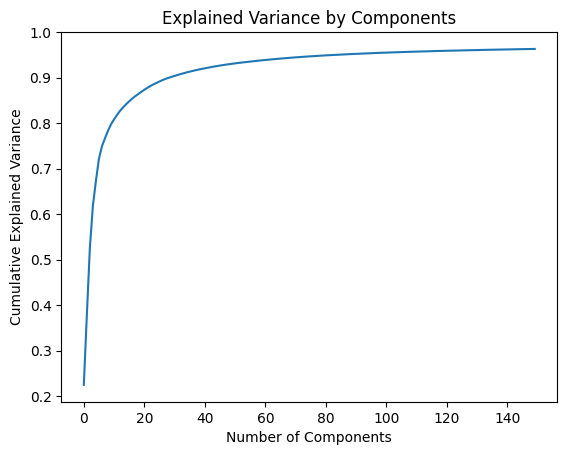

In [7]:
# Calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

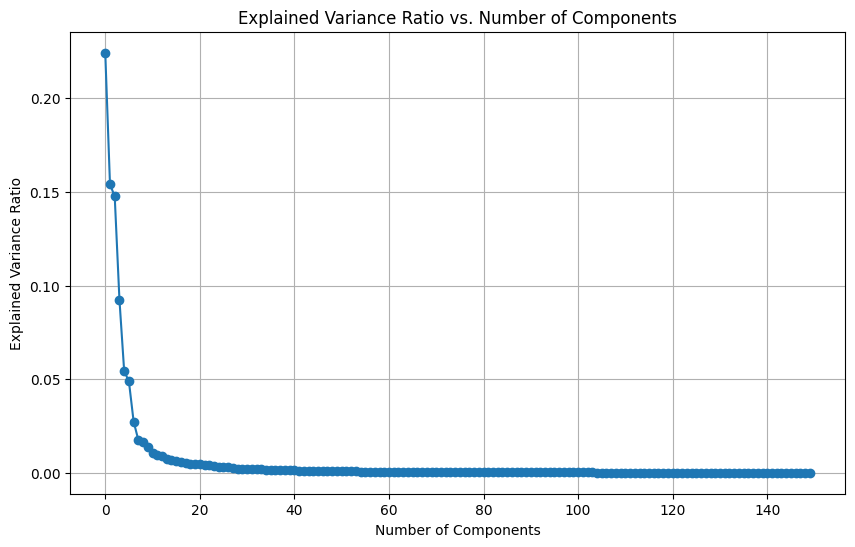

Elbow point (optimal number of components): 1


In [8]:
# Calculate the explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Find the elbow point (where the curve starts to flatten)
elbow_point = np.argmax(np.diff(explained_variance_ratio) < 0.01) + 1
print(f"Elbow point (optimal number of components): {elbow_point}")

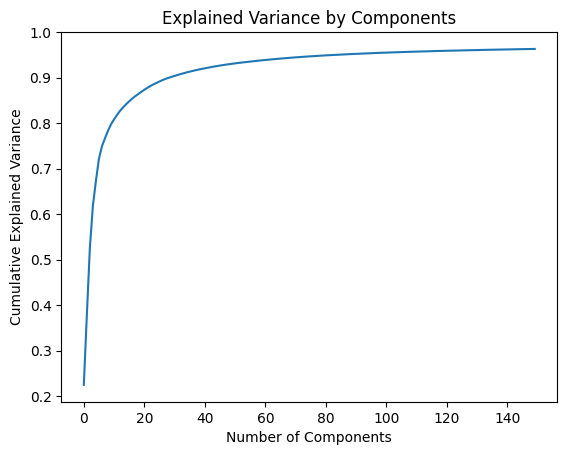

In [9]:
# Calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

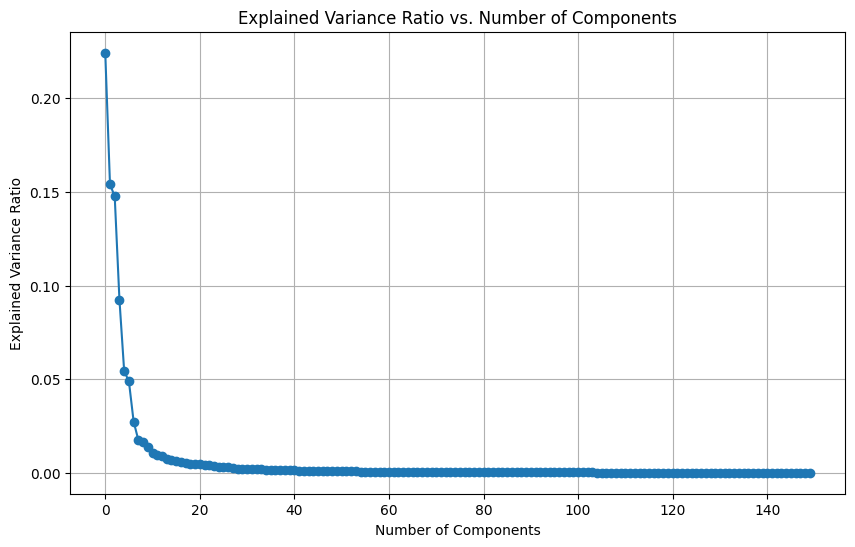

Elbow point (optimal number of components): 1


In [11]:
# Calculate the explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Find the elbow point (where the curve starts to flatten)
elbow_point = np.argmax(np.diff(explained_variance_ratio) < 0.01) + 1
print(f"Elbow point (optimal number of components): {elbow_point}")

In [12]:
# Save the reduce features
with open('X_reduced.pkl', 'wb') as file:
    pickle.dump(X_reduced, file)

In [13]:
# Save the fitted TruncatedSVD object
joblib.dump(svd, "svd_model.pkl")

['svd_model.pkl']

In [14]:
# Load the reduce features
with open('X_reduced.pkl', 'rb') as file:
    X_reduced = pickle.load(file)

In [15]:
from sklearn.ensemble import IsolationForest

# Detect outliers in reduced space
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X_reduced) == -1

In [16]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42, shuffle = True)

In [17]:
# Custom macro F1 score function
def macro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

**LSTM Model**

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

In [19]:
# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [ ]:
# # Step 2: Build the MLP model
# model = Sequential()
# model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(y.shape[1], activation='sigmoid'))  # Multi-label classification

In [ ]:
# # 🧪 Step 3: Compile
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# # 🚀 Step 4: Train
# history = model.fit(
#     X_train, y_train,
#     epochs=200,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1
# )

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 🔧 Liste d’hyperparamètres à tester
param_grid = {
    'hidden1': [128, 256, 512],
    'hidden2': [64, 128, 256],
    'dropout1': [0.2, 0.3],
    'dropout2': [0.2, 0.3],
    'lr': [0.001, 0.0005],
    'batch_size': [32, 64],
    'epochs': [10,15]
}

In [29]:
# 🧠 Fonction pour créer un modèle avec paramètres dynamiques
def create_mlp_model(input_dim, output_dim, hidden1, hidden2, dropout1, dropout2, lr):
    model = Sequential([
        Dense(hidden1, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout1),
        Dense(hidden2, activation='relu'),
        Dropout(dropout2),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# 🎲 Recherche aléatoire (Random Search)
import random
from tqdm import tqdm

results = []
for _ in tqdm(range(10)):  # 10 essais aléatoires
    params = {k: random.choice(v) for k, v in param_grid.items()}

    model = create_mlp_model(
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    hidden1=params['hidden1'],
    hidden2=params['hidden2'],
    dropout1=params['dropout1'],
    dropout2=params['dropout2'],
    lr=params['lr']
)

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
    
    y_pred = model.predict(X_val)
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_val, y_pred_binary, average="macro")
    
    results.append((f1, params))
    print(f"F1 score: {f1:.4f} with params: {params}")

# 🏆 Meilleur résultat
best_result = max(results, key=lambda x: x[0])
print("\n✅ Best Macro F1 Score:", best_result[0])
print("🔧 Best Parameters:", best_result[1])

  0%|          | 0/10 [00:00<?, ?it/s]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 10%|█         | 1/10 [00:18<02:46, 18.55s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.1208 with params: {'hidden1': 256, 'hidden2': 128, 'dropout1': 0.2, 'dropout2': 0.3, 'lr': 0.001, 'batch_size': 64, 'epochs': 15}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 20%|██        | 2/10 [00:29<01:54, 14.30s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.0675 with params: {'hidden1': 128, 'hidden2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.0005, 'batch_size': 64, 'epochs': 10}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 30%|███       | 3/10 [00:51<02:03, 17.60s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.1300 with params: {'hidden1': 512, 'hidden2': 128, 'dropout1': 0.3, 'dropout2': 0.3, 'lr': 0.001, 'batch_size': 64, 'epochs': 15}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 40%|████      | 4/10 [01:12<01:52, 18.83s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.0851 with params: {'hidden1': 128, 'hidden2': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.0005, 'batch_size': 32, 'epochs': 15}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 50%|█████     | 5/10 [01:34<01:41, 20.28s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.1001 with params: {'hidden1': 512, 'hidden2': 128, 'dropout1': 0.3, 'dropout2': 0.3, 'lr': 0.0005, 'batch_size': 32, 'epochs': 10}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 60%|██████    | 6/10 [01:56<01:23, 20.80s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.1374 with params: {'hidden1': 512, 'hidden2': 128, 'dropout1': 0.3, 'dropout2': 0.2, 'lr': 0.001, 'batch_size': 64, 'epochs': 15}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 70%|███████   | 7/10 [02:15<00:59, 19.97s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.1123 with params: {'hidden1': 512, 'hidden2': 64, 'dropout1': 0.3, 'dropout2': 0.3, 'lr': 0.001, 'batch_size': 32, 'epochs': 10}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 80%|████████  | 8/10 [02:35<00:40, 20.12s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.1112 with params: {'hidden1': 512, 'hidden2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.0005, 'batch_size': 64, 'epochs': 15}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
 90%|█████████ | 9/10 [02:48<00:17, 17.75s/it]/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


F1 score: 0.0699 with params: {'hidden1': 512, 'hidden2': 64, 'dropout1': 0.3, 'dropout2': 0.2, 'lr': 0.0005, 'batch_size': 64, 'epochs': 10}
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|██████████| 10/10 [03:08<00:00, 18.85s/it]

F1 score: 0.0917 with params: {'hidden1': 256, 'hidden2': 64, 'dropout1': 0.3, 'dropout2': 0.2, 'lr': 0.0005, 'batch_size': 32, 'epochs': 15}

✅ Best Macro F1 Score: 0.1373696184003672
🔧 Best Parameters: {'hidden1': 512, 'hidden2': 128, 'dropout1': 0.3, 'dropout2': 0.2, 'lr': 0.001, 'batch_size': 64, 'epochs': 15}


In [31]:
# 📊 Step 5: Evaluate
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# 🧮 F1 Score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\n🎯 Macro F1 Score: {macro_f1:.4f}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

🎯 Macro F1 Score: 0.0917


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# Save the model to a file
import joblib

model_filename = "mlp.joblib"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

In [34]:
# Reprendre les meilleurs paramètres
best_params = best_result[1]

# Créer le modèle avec les meilleurs hyperparamètres
final_model = create_mlp_model(
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    hidden1=best_params['hidden1'],
    hidden2=best_params['hidden2'],
    dropout1=best_params['dropout1'],
    dropout2=best_params['dropout2'],
    lr=best_params['lr']
)

# Entraîner le modèle
history = final_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0242 - loss: 0.2775 - val_accuracy: 0.2889 - val_loss: 0.1087
Epoch 2/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2871 - loss: 0.1090 - val_accuracy: 0.3278 - val_loss: 0.1036
Epoch 3/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3299 - loss: 0.1041 - val_accuracy: 0.3335 - val_loss: 0.1008
Epoch 4/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3354 - loss: 0.1016 - val_accuracy: 0.3387 - val_loss: 0.0986
Epoch 5/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3483 - loss: 0.0988 - val_accuracy: 0.3422 - val_loss: 0.0971
Epoch 6/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3409 - loss: 0.0972 - val_accuracy: 0.3454 - val_loss: 0.0959
Epoch 7/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3458 - loss: 0.0967 - val_accuracy: 0.3461 - val_loss: 0.0948
Epoch 8/300
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3462 - loss: 0.0944 - val_accuracy: 0.3480

In [35]:
# Prédictions sur l'ensemble de validation
y_pred = final_model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)

# F1 Score Macro
from sklearn.metrics import f1_score
f1 = f1_score(y_val, y_pred_binary, average='macro')
print(f"✅ Final Macro F1 Score: {f1:.4f}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Final Macro F1 Score: 0.3674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### XGBoost

In [ ]:
# Assign lower weights to outliers instead of removing them
iso = IsolationForest(contamination=0.05, random_state=42).fit(X_train)
sample_weights = np.where(iso.predict(X_train) == -1, 0.1, 1.0)  # Downweight outliers

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute weights for each label (column)
sample_weights = np.array([
    compute_sample_weight('balanced', y_train[:, i]) 
    for i in range(y_train.shape[1])
]).mean(axis=0)  # Average weights across labels

In [ ]:
# %%time

# # Initialize the XGBoost model
# xgb = XGBClassifier(
#     n_estimators=1000,  # Number of boosting rounds
#     max_depth=6,  # Maximum depth of each tree
#     learning_rate=0.1,  # Learning rate
#     subsample=0.8,  # Fraction of samples used for training each tree
#     # colsample_bytree=0.8,  # Fraction of features used for training each tree
#     random_state=42,  # Set random seed for reproducibility
#     n_jobs=-1,  # Use all available CPU cores
#     # eval_metric='mlogloss',  # Evaluation metric for multi-class classification
#     early_stopping_rounds=10  # Stop if no improvement after 10 rounds
# )

# # Train the model with early stopping and verbose evaluation
# xgb.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],  # Validation set for early stopping
#     #early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
#     verbose=True  # Print evaluation results during training
# )

In [ ]:
%%time

# Initialize the XGBoost model
xgb = XGBClassifier(
    n_estimators=1000,  # Number of boosting rounds
    max_depth=6,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate
    subsample=0.8,  # Fraction of samples used for training each tree
    # colsample_bytree=0.8,  # Fraction of features used for training each tree
    # eval_metric='mlogloss',  # Evaluation metric for multi-class classification
    gamma=0,                  # No minimum loss reduction initially
    reg_alpha=0,              # No L1 regularization initially
    reg_lambda=1,             # Standard L2 regularization
    early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set random seed for reproducibility
)

# Train the model with early stopping and verbose evaluation
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    verbose=10  # Print evaluation results during training
)

In [ ]:
%%time

# Initialize the XGBoost model
xgb = XGBClassifier(
    n_estimators=1000,  # Number of boosting rounds
    max_depth=4,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate
    subsample=0.8,  # Fraction of samples used for training each tree
    colsample_bytree=0.8,  # Fraction of features used for training each tree
    # eval_metric='mlogloss',  # Evaluation metric for multi-class classification
    gamma=0.5,                  # No minimum loss reduction initially
    reg_alpha=0.5,              # No L1 regularization initially
    reg_lambda=0.5,             # Standard L2 regularization
    early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
    # n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set random seed for reproducibility
)

# Train the model with early stopping and verbose evaluation
xgb.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    verbose=10  # Print evaluation results during training
)

In [ ]:
%%time

# Initialize the XGBoost model
xgb = XGBClassifier(
    n_estimators=1000,  # Number of boosting rounds
    max_depth=3,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate
    subsample=0.8,  # Fraction of samples used for training each tree
    # colsample_bytree=0.8,  # Fraction of features used for training each tree
    # eval_metric='mlogloss',  # Evaluation metric for multi-class classification
    gamma=0.5,                  # No minimum loss reduction initially
    reg_alpha=0.5,              # No L1 regularization initially
    reg_lambda=1,             # Standard L2 regularization
    early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
    # n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set random seed for reproducibility
)

# Train the model with early stopping and verbose evaluation
xgb.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    verbose=10  # Print evaluation results during training
)

In [ ]:
# Best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Best cross-validation score
print("Best cross-validation accuracy:", random_search.best_score_)

# Train the final model with the best hyperparameters
best_xgb = random_search.best_estimator_
best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    verbose=10  # Print evaluation results every 10 rounds
)

In [ ]:
# Save the model to a file
import joblib

model_filename = "XGBoost_tuned.joblib"
joblib.dump(best_xgb, model_filename)
print(f"Model saved to {model_filename}")

In [ ]:
# Save the model to a file
import joblib

model_filename = "XGBoost_maxdepth3_balanced.joblib"
joblib.dump(xgb, model_filename)
print(f"Model saved to {model_filename}")

In [ ]:
# Evaluate the model
y_pred = xgb.predict(X_val)
print(f"Macro F1 Score: {f1_score(y_val, y_pred, average='macro')}")

In [ ]:
# Evaluate the model
y_pred = best_xgb.predict(X_val)
print(f"Macro F1 Score: {f1_score(y_val, y_pred, average='macro')}")

### LightGBoost

In [ ]:
# # Initialize the LGBMClassifier
# lgb = LGBMClassifier(
#     #objective='multiclass',  # Use 'multiclass' for multi-class classification
#     #num_class=453,  # Number of classes in your target variable (y)
#     n_estimators=100,  # Maximum number of boosting rounds
#     learning_rate=0.1,  # Learning rate
#     num_leaves=31,  # Maximum number of leaves in one tree
#     feature_fraction=0.8,  # Fraction of features to use for each tree
#     bagging_fraction=0.8,  # Fraction of data to use for each tree
#     random_state=42,  # Random seed for reproducibility
#     # n_jobs=-1,  # Use all available CPU cores
#     # device='gpu'  # Enable GPU acceleration
# )

# # Train the model with early stopping
# lgb.fit(
#     X_train, y_train
#     #eval_set=[(X_val, y_val)],  # Validation set for early stopping
#     #eval_metric=macro_f1_score_lgb,  # Use the custom macro F1 metric
#     # early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
#     # verbose=10  # Print evaluation results every 10 rounds
# )

In [ ]:
# # Encode the multi-label target into a 1-dimensional array
# # Example: Convert multi-label to a single label by finding the first active label for each sample
# y_train_encoded = np.argmax(y_train, axis=1)
# y_val_encoded = np.argmax(y_val, axis=1)

# # Convert the data into LightGBM Dataset format
# train_data = lgb.Dataset(X_train, label=y_train_encoded)
# valid_data = lgb.Dataset(X_val, label=y_val_encoded, reference=train_data)

In [ ]:
# # Set up the parameters for LightGBM
# params = {
#     'objective': 'multiclass',  # Use 'multiclass' for multi-class classification
#     'num_class': 453,  # Number of classes in your target variable (y)
#     'metric': 'None',  # Disable default metric since we're using a custom metric
#     'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
#     'num_leaves': 6,  # Maximum number of leaves in one tree
#     'learning_rate': 0.1,  # Learning rate
#     'feature_fraction': 0.1,  # Fraction of features to use for each tree
#     'bagging_fraction': 0.1,  # Fraction of data to use for each tree
#     'verbose': 1,  # Suppress LightGBM logs
#     'seed': 42,  # Random seed for reproducibility
#     # 'device': 'gpu'  # Enable GPU acceleration
# }

# # Define early stopping callback
# # early_stopping_callback = lgb.early_stopping(stopping_rounds=10, verbose=True)
# verbose_eval_callback = lgb.log_evaluation(period=1)  # Print evaluation results every 1 round

# # Train the model with early stopping
# model = lgb.train(
#     params,
#     train_data,
#     num_boost_round=100,  # Maximum number of boosting rounds
#     valid_sets=[valid_data],  # Validation set for early stopping
#     callbacks=[verbose_eval_callback],  # Enable early stopping and verbose evaluation
# )

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# # Make predictions on the test set
# y_pred_prob = model.predict(X_val, num_iteration=model.best_iteration)
# y_pred_class = np.argmax(y_pred_prob, axis=1)

# # Calculate the final macro F1 score
# final_f1 = f1_score(y_val_encoded, y_pred_class, average='macro')
# print(f"Final Macro F1 Score: {final_f1:.4f}")

In [ ]:
# # Save the model to a file
# import joblib

# model_filename = "LGBM.joblib"
# joblib.dump(lgb, model_filename)
# print(f"Model saved to {model_filename}")

## Testing on Real Unseen Data

In [ ]:
def parse_cfg(file_path):
    """
    Parse a CFG file and extract assembly instructions.
    """
    with open(file_path, 'r') as f:
        cfg_data = f.read()

    # Extract nodes and their labels
    nodes = re.findall(r'"([^"]+)"\s*\[label\s*=\s*"([^"]+)"\]', cfg_data)

    # Extract edges (control flow)
    edges = re.findall(r'"([^"]+)"\s*->\s*"([^"]+)"', cfg_data)

    # Extract assembly instructions from node labels
    instructions = []
    for node_id, label in nodes:
        # Extract the instruction part (e.g., "mov eax, 1")
        instruction = label.split(":")[-1].strip()
        instructions.append(instruction)

    return instructions, nodes, edges

In [ ]:
# Process all CFG files
cfg_dir = "/kaggle/input/cfg-test/folder_test_set"

all_instructions_test = []  # List to store instructions from all CFGs


# Get the list of JSON file names
json_files = [filename for filename in os.listdir(cfg_dir) if filename.endswith(".json")]

batch_size = 1000
# Process files in batches to avoid getting Memory Error since the data is too large
for i in range(0, len(json_files), batch_size):
    batch_files = json_files[i:i + batch_size]
    for filename in batch_files:
        file_path = os.path.join(cfg_dir, filename)
        instructions, nodes, edges = parse_cfg(file_path)

        # Append
        all_instructions_test.append(" ".join(instructions))  # Combine instructions into a single string

In [ ]:
len(all_instructions_test)

In [ ]:
# # Save the combined list to a file (optional)
# with open("all_instructions_test.pkl", "wb") as f:
#     pickle.dump(all_instructions_test, f)

In [ ]:
# Initialize the HashingVectorizer
vectorizer = HashingVectorizer(n_features=2**14)  # Adjust n_features as needed

# Process data in batches
batch_size = 20  # Reduce the batch size
output_dir = "tfidf_batches_test"
os.makedirs(output_dir, exist_ok=True)

try:
    for i in range(0, len(all_instructions_test), batch_size):
        # Get the current batch of instructions
        batch_instructions = all_instructions_test[i:i + batch_size]

        # Apply HashingVectorizer to the batch
        X_batch = vectorizer.transform(batch_instructions)

        # Save the batch to disk
        save_npz(os.path.join(output_dir, f"batch_{i}.npz"), X_batch)
        print(f"Processed and saved batch {i // batch_size + 1} of {len(all_instructions_test) // batch_size + 1}")
        
except MemoryError:
    print(f"MemoryError encountered at batch {i // batch_size + 1}. Skipping...")

In [ ]:
# Directories
input_dir = "tfidf_batches_test"   # Directory containing batch files
chunk_dir = "tfidf_chunks_test"    # Directory to save chunked files
final_output = "tfidf_matrix_final_test.npz"  # Final merged matrix file

# Create the chunk directory if it doesn't exist
os.makedirs(chunk_dir, exist_ok=True)

# List all batch files
batch_files = sorted([f for f in os.listdir(input_dir) if f.startswith("batch_")], 
                     key=lambda x: int(x.split("_")[1].split(".")[0]))

# Process in chunks
chunk_size = 10  # Adjust based on memory limits
chunk_index = 0

for i in range(0, len(batch_files), chunk_size):
    batch_subset = batch_files[i:i + chunk_size]
    print(f"Processing chunk {chunk_index + 1}/{len(batch_files) // chunk_size + 1}...")

    batch_matrices = [load_npz(os.path.join(input_dir, batch_file)) for batch_file in batch_subset]
    X_subset = vstack(batch_matrices)  # Stack only this subset

    # Save the subset to the chunk directory
    chunk_path = os.path.join(chunk_dir, f"chunk_{chunk_index}.npz")
    save_npz(chunk_path, X_subset)
    
    # Free memory
    del batch_matrices, X_subset
    gc.collect()
    
    chunk_index += 1

print("Chunked processing complete. Now merging final chunks...")

# Merge all saved chunks
chunk_files = sorted([f for f in os.listdir(chunk_dir) if f.startswith("chunk_")], 
                     key=lambda x: int(x.split("_")[1].split(".")[0]))
X_final_test = None

for chunk_file in chunk_files:
    chunk_path = os.path.join(chunk_dir, chunk_file)
    X_chunk = load_npz(chunk_path)
    
    if X_final_test is None:
        X_final_test = X_chunk
    else:
        X_final_test = vstack([X_final_test, X_chunk])
    
    # Free memory after merging each chunk
    del X_chunk
    gc.collect()
    
# Save the final merged matrix
save_npz(final_output, X_final_test)
print(f"Final matrix saved successfully at {final_output}!")

In [ ]:
# Load the sparse matrix and labels
X_final_test = load_npz("/kaggle/input/cfg-preapared-dataset/tfidf_matrix_final_test.npz")

In [ ]:
X_final_test.shape

In [ ]:
# Reduce dimensionality to 1000 features
X_reduced_test = svd.transform(X_final_test)

In [ ]:
X_reduced_test = X_reduced_test[:, :100]

In [ ]:
X_reduced_test.shape

In [ ]:
# Save the reduce features
with open('X_reduced_test_100.pkl', 'wb') as file:
    pickle.dump(X_reduced_test, file)

In [ ]:
# Load the reduce features
with open('X_reduced_test_100.pkl', 'rb') as file:
    X_reduced_test = pickle.load(file)

In [ ]:
# Load the model from the file
mlp = joblib.load("/kaggle/working/mlp.joblib")

In [ ]:
# Evaluate the model
y_pred = model.predict(X_reduced_test)

In [ ]:
y_pred = (y_pred > 0.5).astype(int)

In [ ]:
# Get the filename in the test folder
cfg_dir = "/kaggle/input/cfg-test/folder_test_set"

# all_instructions_test = []  # List to store instructions from all CFGs
all_filenames_test = [] # List to store filenames


# Get the list of JSON file names
json_files = [filename for filename in os.listdir(cfg_dir) if filename.endswith(".json")]

batch_size = 1000
# Process files in batches to avoid getting Memory Error since the data is too large
for i in range(0, len(json_files), batch_size):
    batch_files = json_files[i:i + batch_size]
    for filename in batch_files:
        file_path = os.path.join(cfg_dir, filename)
        # instructions, nodes, edges = parse_cfg(file_path)
        
        # Remove the .json extension from the filename
        filename_without_extension = os.path.splitext(filename)[0]

        # Append
        # all_instructions_test.append(" ".join(instructions))  # Combine instructions into a single string
        all_filenames_test.append(filename_without_extension)  # Store the filename

In [ ]:
len(all_filenames_test)

In [ ]:
all_filenames_test[0]

In [ ]:
# Load the CSV file with empty label columns
empty_label_csv = pd.read_excel("/kaggle/input/test-metadata/test_set_metadata_to_predict.xlsx")  # Replace with your file
empty_label_filenames = empty_label_csv["name"]  # Assuming the column is named "filename"

In [ ]:
empty_label_filenames[0]

In [ ]:
# Create a dictionary to map filenames to predictions
filename_to_prediction = dict(zip(all_filenames_test, y_pred))

# Get the list of label columns (all columns except 'filename')
label_columns = empty_label_csv.columns[1:]  # Assuming 'filename' is the first column

# Fill the empty label columns in the CSV file
for i, filename in enumerate(empty_label_filenames):
    if filename in filename_to_prediction:
        # Assign the predictions to all label columns at once
        empty_label_csv.loc[i, label_columns] = filename_to_prediction[filename]
    else:
        # Fill missing filenames with default values (e.g., 0)
        empty_label_csv.loc[i, label_columns] = 0

# Save the filled excel file
empty_label_csv.to_excel("mlp.xlsx", index=False)